In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import itertools

In [28]:
df = pd.read_csv(
    "../datasets/breast_cancer.csv", 
    usecols = [
        "radius_mean", "texture_mean", "perimeter_mean", "area_mean", 
        "smoothness_mean", "compactness_mean", "concavity_mean", 
        "concave points_mean", "symmetry_mean", "fractal_dimension_mean", 
        "diagnosis" 
    ]
)

df.rename(columns={
    "radius_mean": "radius",
    "texture_mean": "texture",
    "perimeter_mean": "perimeter",
    "area_mean": "area",
    "smoothness_mean": "smoothness",
    "compactness_mean": "compactness",
    "concavity_mean": "concavity",
    "concave points_mean": "concave_points",
    "symmetry_mean": "symmetry",
    "fractal_dimension_mean": "fractal_dimension",
    "diagnosis": "diagnosis"
}, inplace = True)

df['diagnosis'].replace({
    "M": 1,  
    "B": 0   
}, inplace = True)

df_filtered = df[df['diagnosis'].isin([0, 1])]

num_rows = len(df_filtered)

if num_rows >= 1000:
    df_sample = df_filtered.sample(n = 1000, random_state = 42)
else:
    df_sample = df_filtered

df_sample.head()

/tmp/ipykernel_5088/2501444660.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['diagnosis'].replace({
/tmp/ipykernel_5088/2501444660.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['diagnosis'].replace({


,diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [29]:
X = df_sample[[
    "radius", "texture", "perimeter", "area", 
    "smoothness", "compactness", "concavity", 
    "concave_points", "symmetry", "fractal_dimension"
]] 

y = df_sample['diagnosis']

corr_matrix = X.corr()

target_corr = df_sample.corr()['diagnosis']

/tmp/ipykernel_5088/2700000468.py:11: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


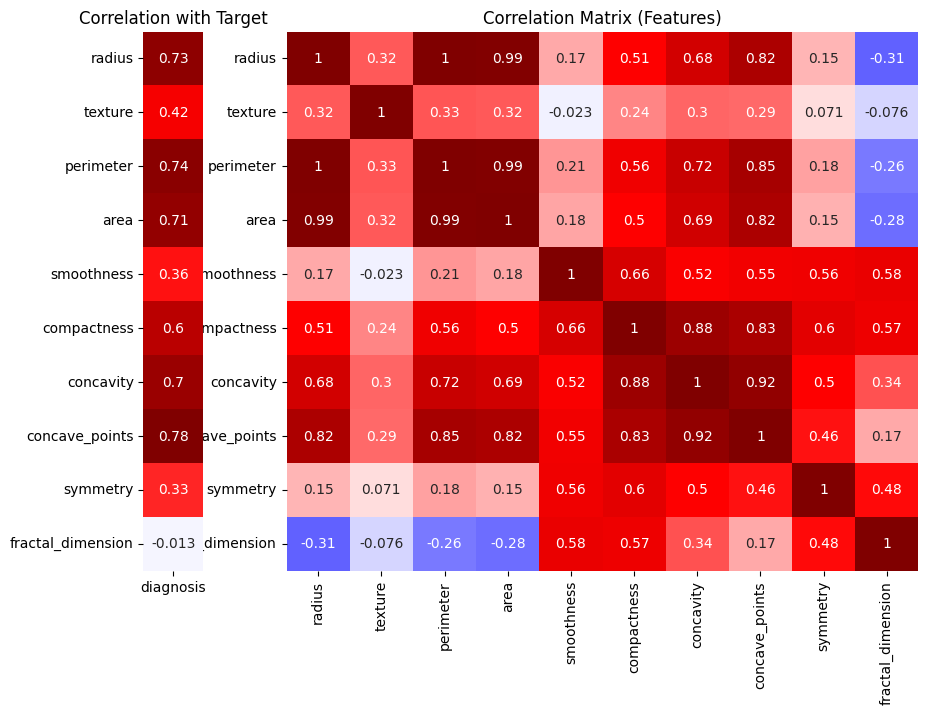

In [30]:
plt.figure(figsize=(10, 7))

ax1 = plt.subplot(1, 11, (3, 11))  
sns.heatmap(corr_matrix, annot=True, cmap='seismic', cbar=False, ax=ax1, center=0)
ax1.set_title('Correlation Matrix (Features)', fontsize=12)

ax2 = plt.subplot(1, 11, 1)  
sns.heatmap(target_corr.drop('diagnosis').to_frame(), annot=True, cmap='seismic', cbar=False, ax=ax2, center=0)
ax2.set_title('Correlation with Target', fontsize=12)

plt.tight_layout()
plt.show()

In [31]:
def split_features_target(df, target_column):

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    return X, y

In [32]:
def train_test_split_scaled(X, y, test_size=0.3, random_state=42, scale=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Normalizing the data
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

## Lasso

In [33]:
# Set feature variable and target variable
X, y = split_features_target(df_sample, "diagnosis")

print(X.shape) 
print(y.shape)

(569, 10)
(569,)


In [34]:
# Splitting the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split_scaled(X, y, test_size=0.3, random_state=42)

# Applying LASSO
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=0.05) 
lasso_model.fit(X_train, y_train)

y_proba = lasso_model.predict_proba(X_test)[:, 1]

coef = pd.Series(lasso_model.coef_[0], index=X.columns)
selected_features = coef[coef != 0]
print("Features selected by LASSO:\n")
print(selected_features) 

Features selected by LASSO:

radius            0.701958
texture           0.299332
concave_points    1.857723
dtype: float64


In [35]:
# Model evaluation
y_pred = lasso_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.9181286549707602


In [36]:
# Calculate AUROC
auroc = roc_auc_score(y_test, y_proba)
print(f"AUROC of model: {auroc}")

AUROC of model: 0.9866255144032922


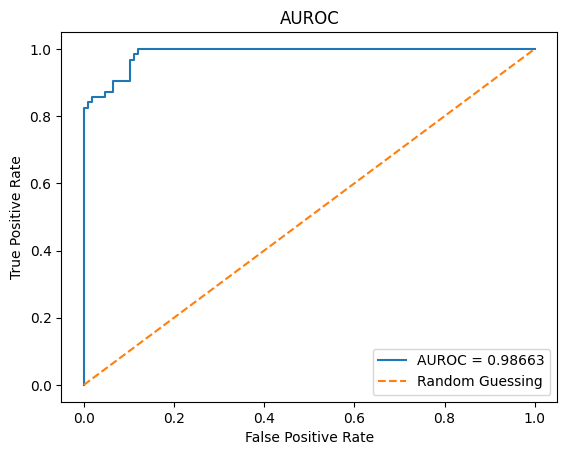

In [37]:
#Plot the graph
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.5f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC')
plt.legend()
plt.show()

## RFE

In [38]:
X, y = split_features_target(df_sample, "diagnosis")

print(X.shape) 
print(y.shape)

(569, 10)
(569,)


In [39]:
# Splitting the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split_scaled(X, y, test_size=0.3, random_state=42)

log_reg = LogisticRegression(solver='liblinear')

rfe = RFE(log_reg, n_features_to_select=6) #number of features selected

rfe.fit(X_train, y_train)

selected_features = X.columns[rfe.support_]
print("Features selected by RFE:\n")
print(selected_features)

Features selected by RFE:

Index(['radius', 'texture', 'area', 'smoothness', 'concavity',
       'concave_points'],
      dtype='object')


In [40]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

log_reg.fit(X_train_rfe, y_train)

# Model evaluation
accuracy = log_reg.score(X_test_rfe, y_test)
print(f"Model Accuracy [RFE]: {accuracy}")

Model Accuracy [RFE]: 0.9532163742690059


In [41]:
X_test_rfe = rfe.transform(X_test)
y_proba = log_reg.predict_proba(X_test_rfe)[:, 1] 

#Calculete AUROC
auroc = roc_auc_score(y_test, y_proba)
print(f"AUROC of model RFE: {auroc}")

AUROC of model RFE: 0.9930922986478542


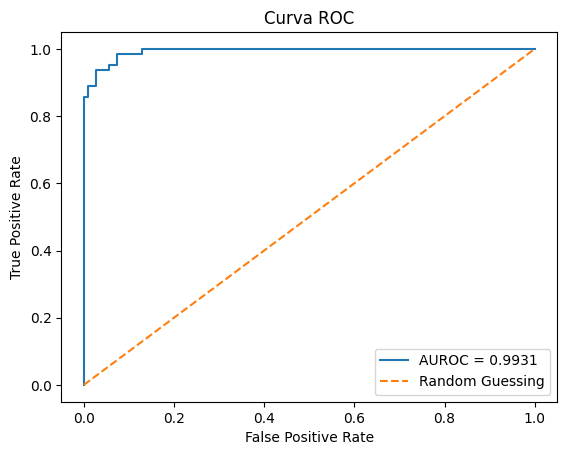

In [42]:
#Plot the graph
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

## Optimum

In [43]:
X, y = split_features_target(df_sample, "diagnosis")
print(X.shape) 
print(y.shape)


(569, 10)
(569,)


In [44]:
# Function to calculate the sum of correlations with the target
def sumFeatureTarget(z, target_corr):
    sum_value = 0
    for i in range(len(z)):
        sum_value += z[i] * abs(target_corr.iloc[i])
    return sum_value

# Function to calculate the sum of correlations between features
def sumFeatureFeature(z, corr_matrix):
    sum_value = 0
    for i in range(len(z)):
        for j in range(len(z)):
            if i != j:
                sum_value += z[i] * z[j] * abs(corr_matrix.iloc[i, j])
    return sum_value

In [46]:
# Brute force function to select best features
def brute_force(phi, combinations, target_corr, corr_matrix):
    min_value = float('inf')
    best_features = []
    
    for combination in combinations:
        h = -((phi * sumFeatureTarget(combination, target_corr)) - ((1 - phi) * sumFeatureFeature(combination, corr_matrix)))
        
        if h < min_value:
            min_value = h
            best_features = combination
    
    # Returns the index of the selected features
    selected_features = [i for i, val in enumerate(best_features) if val == 1]
    return selected_features, min_value

In [49]:
# Returns the index of the selected features
combinations = list(itertools.product([0, 1], repeat=10)) 
combinations = np.array(combinations)

combinations = combinations[1:] 
mask = np.sum(combinations, axis=1) != 1  
combinations = combinations[mask]

In [57]:
# Correlation matrix with the target (target_corr) and between the features (corr_matrix)
target_corr = df_sample.corr()['diagnosis'][:-1]  
corr_matrix = df_sample.corr().drop('diagnosis', axis=1).drop('diagnosis', axis=0) 

phi = 0.75

best_features, best_value = brute_force(phi, combinations, target_corr, corr_matrix)

print(f"Best Features): {best_features}")
print(f"Best value of h: {best_value}")

Best Features): [0, 1, 4, 8]
Best value of h: -1.7643853385019834


In [58]:
# Name of the best features
feature_names = df_sample.columns[:-1] 
selected_feature_names = feature_names[best_features]
print(f"Name of the best features:\n{selected_feature_names}")

Name of the best features:
Index(['diagnosis', 'radius', 'area', 'concave_points'], dtype='object')
